另外一个 LightGCN MovieLens 的 [notebook] (http://localhost:8888/notebooks/PyTorch_RecSys/LightGCN_for_Movie_Rec%20/LightGCN%20for%20Movie%20Recommendation%20by%20Quinn%20Wang.ipynb) 看的实在是太 struggle 了，而且 recall 非常低，肯定是哪里没写对，我一步步 debug ，不如先看一下这个，我突然找到这个也是 Stanford 224W 的，也是 LightGCN， 也是 Movie Lens

- Blog: https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e
- Code: https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing


突然发现这个内容好像似曾相识啊.. 难道我很早以前就看过?

Update:

    - 还是 model 得用 threshold = 1 然后 eval 的时候 therhold = 3.5， 不然我等于edge_Index filter by trheshold 之后，变成是只给 所有 relevant item 的集合让 model 来从中选来推荐，当然 reall 会非常高 (recall_at_k 0.84509, precision_at_k 0.91002)。 so instead, I want to give model all the edges including the rating = 1 edges and let model learn because we are giving the labels with ratings. 
          - result: [Iteration 9400/10000], train_loss: 0.85635, val_loss: 0.85697,  recall_at_k 0.19081, precision_at_k 0.29305
          
    - 试一下， 用 layer 小一点 比如 1? （倒是 train 快了很多)。 
        - result: [Iteration 9800/10000], train_loss: 0.77699, val_loss: 0.80771,  recall_at_k 0.22017, precision_at_k 0.3126。 for test set: recall_at_k 0.20615, precision_at_k 0.29663




# Imports

In [1]:
# import required modules
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F

# Load Dataset

In [2]:
# download the dataset
# Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [3]:
rating_df = pd.read_csv(rating_path)

lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [4]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [5]:
# ------ new -----
# load edges between users and movies
def load_edge_csv(df, 
                  src_index_col, 
                  dst_index_col,  
                  link_index_col, 
                  rating_threshold=3.5):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    
    edge_index = None
    src = [user_id for user_id in  df['userId']]
    
    num_users = len(df['userId'].unique())
    
    # dst 全部 offset by num_users ，因为是 bipartite graph
#     dst = [(movie_id + num_users) for movie_id in df['movieId']]
    # 改回来
    dst = [(movie_id) for movie_id in df['movieId']]
    
    link_vals = df[link_index_col].values

    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold
    # edge_values = torch.from_numpy(df[link_index_col].values).view(-1, 1)

    edge_values = []

    # 这里就是把 上面的 src list (user), dst list (item), edge_attr(boolean), 转成 PyG Edge_index 需要的COO 格式
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
            edge_values.append(link_vals[i])

    return edge_index, edge_values




# 这里 print 出来之后，直接就是 COO 格式了!! 即 2 x num_edge_pair. 就是 pyG tutorial 的第一个tutorial 里面的


In [6]:

edge_index, edge_values = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
#     rating_threshold=1, # 这里用 1 因为 lightGCN 假设只要 有 interaction 就算
#     rating_threshold=3, # 改成 3 试一下
#     rating_threshold=3.5, # 改成 3.5 试一下, 理论上应该是 recall 会升的更快？因为 true relevant item 基数小了呀
    rating_threshold=1 # 还是得改为 1 因为不然你的 test and val set 就都完全没有给 irrelevant item 推荐了， 所以 recall 奇高
)

In [7]:
edge_index = torch.LongTensor(edge_index) # 如果不是 SparseTensor， 那么.propagate 需要 longTensor
edge_values = torch.tensor(edge_values)

print(edge_index)
print(edge_index.size())

print(edge_values)
print(edge_values.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])
torch.Size([2, 99466])
tensor([4., 4., 4.,  ..., 5., 5., 3.], dtype=torch.float64)
torch.Size([99466])


In [8]:
# split the edges of the graph using a 80/10/10 train/validation/test split
# num_users, num_movies = len(user_mapping), len(movie_mapping)

num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

print(f"num_users {num_users}, num_movies {num_movies}")

num_users 610, num_movies 9724


In [9]:
# 这个其实做的是 convert_r_mat_edge_index_to_adj_mat_edge_index
def convert_bipartate_edge_index_to_edge_index(input_edge_index, input_edge_values):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
#         R[row_idx][col_idx] = 1
        R[row_idx][col_idx] = input_edge_values[i]

    R_transpose = torch.transpose(R, 0, 1)
    
    # create empty adj_matrix
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    # 这边严格按照 lightGCN formulat 6 来建 bipartite 的 adj graph
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    
    # 从 COO 拿 values
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [10]:
# 这里其实是算的  threshold filter 之后的 
num_interactions = edge_index.shape[1]
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")


num_users 610, num_movies 9724, num_interactions 99466


In [11]:
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

# 诶，原来 validation 是从test set 里面再 split 出来，我一直以为是从给training set
val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

In [12]:
# 这里就是拿到 edge pair index 其实还是 tensor, 
# 所以这里其实就是 把 edge_index 拆成 training set, validation set, test set... 
train_edge_index = edge_index[:, train_indices]
train_edge_value = edge_values[train_indices]

val_edge_index = edge_index[:, val_indices]
val_edge_value = edge_values[val_indices]

test_edge_index = edge_index[:, test_indices]
test_edge_value = edge_values[test_indices]

In [13]:
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(edge_index[0]).size())
print(torch.unique(edge_index[1]).size())
print(train_edge_index.min())
print(train_edge_index.max())
print(edge_index.max())

print(test_edge_value)
print(test_edge_value.size())

train_edge_index tensor([[ 239,  102,  225,  ...,   34,  488,  609],
        [ 274, 9006,  792,  ...,  260, 1486, 3867]])
10334
torch.Size([610])
torch.Size([9628])
tensor(0)
tensor(9723)
tensor(9723)
tensor([4.5000, 3.5000, 3.5000,  ..., 3.5000, 5.0000, 1.0000],
       dtype=torch.float64)
torch.Size([9947])


In [14]:
# 这里得把上面的转成 bipartite
# 那我的edge values 咋办?, 也一同穿进去
train_edge_index, train_edge_values  = convert_bipartate_edge_index_to_edge_index(train_edge_index, train_edge_value)
val_edge_index, val_edge_values = convert_bipartate_edge_index_to_edge_index(val_edge_index, val_edge_value)
test_edge_index, test_edge_values = convert_bipartate_edge_index_to_edge_index(test_edge_index, test_edge_value)

In [15]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

print(f"\n train_edge_values: \n {train_edge_values} \n {train_edge_values.size()}")
print(f"\n val_edge_values: \n {val_edge_values} \n {val_edge_values.size()}")
print(f"\n test_edge_values: \n {test_edge_values} \n {test_edge_values.size()}")

tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]])
torch.Size([2, 159144])
tensor([[    0,     0,     0,  ..., 10312, 10316, 10327],
        [  612,   699,   924,  ...,   247,    49,   183]])
torch.Size([2, 19894])
tensor([[    0,     0,     0,  ..., 10302, 10307, 10310],
        [  656,   734,   746,  ...,   513,   211,   337]])
torch.Size([2, 19894])

 train_edge_values: 
 tensor([4.0000, 4.0000, 5.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([159144])

 val_edge_values: 
 tensor([4.0000, 5.0000, 4.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([19894])

 test_edge_values: 
 tensor([5.0000, 5.0000, 5.0000,  ..., 3.0000, 4.5000, 2.5000]) 
 torch.Size([19894])


# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

## Matrix Form
In our implementation, we utilize the matrix form of LightGCN. We perform multi-scale diffusion to obtain the final embedding, which sums embeddings diffused across multi-hop scales. 

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix



__TODO__: 上面这个有点没看懂，得查一下
- https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix
- [拉普拉斯矩阵(Laplacian Matrix) 及半正定性证明](https://www.cnblogs.com/shiyublog/p/9785342.html)
- 我大概知道了，按陈学长跟我讲的去复习一下，然后先把 RMSE 的方法弄一下，然后回头再看下面这几个资料
    - [SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1609.02907.pdf%EF%BC%89)
    - [LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation](https://arxiv.org/pdf/2002.02126.pdf) 尤其 formula 7
    - https://en.m.wikipedia.org/wiki/Laplacian_matrix
    - PyG GCN Norm Doc [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.GCNNorm), [source code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/transforms/gcn_norm.html#GCNNorm)
    - PyG 的 LG_CONV (单层的) Light GCN [link](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/lg_conv.html#LGConv)
    - PyG 的Light GCN 整个 network [link](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/lightgcn.html)
    - Normalized Adjacency and Laplacian Matrices Cornell Slides [link](https://people.orie.cornell.edu/dpw/orie6334/Fall2016/lecture7.pdf)
    - [SO]Interpretation of Symmetric Normalised Graph Adjacency Matrix [link](https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix)
- 这个有几个问题，一个是 bipartate graph 的 Adj Matrix 他是不是没有设置好，
- 


In [16]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # 这边 embedding 就参考 我的 Basic NCF 的那个 notebook 
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, 
                                      embedding_dim=self.embedding_dim) # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, 
                                      embedding_dim=self.embedding_dim) # e_i^0

        # 这啥？哦就是 上面两 embedding 的 initialization 方法， 当然，也可以把 feature 放进来作为初始 embeding
        # "Fills the input Tensor with values drawn from the normal distribution"
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)
        # 128 因为我直接 两个 64 len 的 embedding concat
        self.out = nn.Linear(128, 1)

    def forward(self, edge_index: Tensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        # TODO: 这个是啥骚操作? 这边得仔细看一下!!! (上面我有做笔记了.)
        # 这里 print 出来之后，长度可能跟 edge_index 不一样了，因为有加 selfloop， 到时候可以验证一下
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # 直接 user, item embedding concat 然后套一曾，然后 rename??
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        # 哦，不是套一层，而是因为 lightGCN 最后从 多跟 emb_k 算出 emb 是直接加， 所以这里建一个 list
        # 你看后面 propagate 多层 LightGCN layer 的时候，一方面 propagate， 一方面每一层我都 append 到 embs 这个list
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        # 这个跟你用几层 LightGCn 有关，一层，你都 
        # 注意这里，咱们是用 emb_k 作为 node  的 feature 了!!!  
        # TODO: 可以思考一下这里要加真正的 node feature 怎么加？直接 concat? 补进去?
        for i in range(self.K):
            # 他着跟这里讲的不太一样呀？“For bipartite graphs with two independent sets of nodes and indices, and each set holding its own information, this split can be marked by passing the information as a tuple, e.g. x=(x_N, x_M)”
            # https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html?highlight=bipartate#the-messagepassing-base-class
            # emb_k = self.propagate(edge_index_norm, x=emb_k)
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)

        # 这个到时候可以看一下 dim=1 的 stack 长啥样
        # 可以参考这个 https://www.geeksforgeeks.org/python-pytorch-stack-method/
        # 就是比如 [[1,2,3,4], [5,6,7,8]]
        # stack 完变成[ [1,5], [2,6],[3, 7], [4, 8] ]
        embs = torch.stack(embs, dim=1)
        
        # 然后这边就是把上面 stack 完的求均值
        # Q: ?? lightGCN 是求均值吗? 不是应该是 weighted sum?? 不过 sum or avg 应该都不影响结果
        # A: 看 paper 里面， 公式里的 a 其实是 1/(K+1) 那本质上就是 avg 了
        emb_final = torch.mean(embs, dim=1) # E^K

        # 这个比较 straightforward, 我们上面 embedding 不是用 concat 把 user_emb 和 item_emb 给
        # horizontal 连起来吗， 这里跑完 LightGCN layer 之后，我们就可以在 split 拆开左右两边，拿到各种的 embedding
        # 那其实跟 NCF 还是蛮像的.
        users_emb_final, items_emb_final = torch.split(emb_final, 
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        
        row, col =  edge_index[0], edge_index[1]
        
        user_embeds = emb_final[row]
        movie_embeds = emb_final[col]
        
        output = torch.cat([user_embeds, movie_embeds], dim=1)
        
        # self.training is inherited from nn.Module
        # let's remove the dropout to see if it will learn faster
        # output = F.dropout(output, self.dropout_rate, self.training)
        
        output = self.out(output)
        
        return output
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

# layers = 3    
layers = 1 # 试一下 1 是提高还是下降? 
model = LightGCN(num_users=num_users, 
                 num_items=num_movies, 
                 K=layers)

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

# Training

Your test set performance should be in line with the following (*K=20*):

*Recall@K: 0.13, Precision@K: 0.045, NDCG@K: 0.10*

In [17]:
# define contants
ITERATIONS = 10000
EPOCHS = 10
# ITERATIONS = 20
BATCH_SIZE = 1024
# 我觉得下面写的有点问题，不然我每个 batch 都是全部数据吧?
# BATCH_SIZE = len(train_edge_index[0])

LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
# K = 10
# K = 10 是不是太多了?? 这个会导致 layer oversmooth? 不过好像没有用这个 K? 哦，不是，这个是 eval metric的 K 
K = 10
LAMBDA = 1e-6
# LAMBDA = 1/2

In [18]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [19]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

# add decay to avoid overfit
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)
# optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
# train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
# val_sparse_edge_index = val_sparse_edge_index.to(device)

loss_func = nn.MSELoss()

Using device cpu.


In [20]:
 def get_recall_at_k(input_edge_index, input_edge_values, pred_ratings, k=10, threshold=3.5):
    with torch.no_grad():
        user_item_rating_list = defaultdict(list)

        for i in range(len(input_edge_index[0])):
            src = input_edge_index[0][i].item()
            dest = input_edge_index[1][i].item()
            true_rating = input_edge_values[i].item()
            pred_rating = pred_ratings[i].item()

            user_item_rating_list[src].append((pred_rating, true_rating))

        recalls = dict()
        precisions = dict()

        for user_id, user_ratings in user_item_rating_list.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        overall_recall = sum(rec for rec in recalls.values()) / len(recalls)
        overall_precision = sum(prec for prec in precisions.values()) / len(precisions)

        return overall_recall, overall_precision
    

In [21]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation

    pred_ratings = model.forward(train_edge_index)

    train_loss = loss_func(pred_ratings, train_edge_values.view(-1,1))    
#     print(f"train_loss {train_loss}")
        
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # 这里就是过 validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            val_pred_ratings = model.forward(val_edge_index)
            
            val_loss = loss_func(val_pred_ratings, val_edge_values.view(-1,1)).sum()

            recall_at_k, precision_at_k = get_recall_at_k(val_edge_index, 
                                                          val_edge_values, 
                                                          val_pred_ratings)
    
                
            val_recall_at_ks.append(round(recall_at_k, 5))
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
        
            print(f"[Iteration {iter}/{ITERATIONS}], train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)},  recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")

        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000], train_loss: 13.55275, val_loss: 13.53169,  recall_at_k 0.0, precision_at_k 0.0
[Iteration 200/10000], train_loss: 2.3853, val_loss: 2.49956,  recall_at_k 0.00793, precision_at_k 0.04536
[Iteration 400/10000], train_loss: 1.55158, val_loss: 1.62412,  recall_at_k 0.04222, precision_at_k 0.12383
[Iteration 600/10000], train_loss: 1.31031, val_loss: 1.37528,  recall_at_k 0.06264, precision_at_k 0.15467
[Iteration 800/10000], train_loss: 1.18693, val_loss: 1.24781,  recall_at_k 0.08145, precision_at_k 0.17704
[Iteration 1000/10000], train_loss: 1.10896, val_loss: 1.16722,  recall_at_k 0.09557, precision_at_k 0.19228
[Iteration 1200/10000], train_loss: 1.0541, val_loss: 1.11059,  recall_at_k 0.10593, precision_at_k 0.20337
[Iteration 1400/10000], train_loss: 1.0129, val_loss: 1.06814,  recall_at_k 0.11566, precision_at_k 0.21407
[Iteration 1600/10000], train_loss: 0.98058, val_loss: 1.03487,  recall_at_k 0.12336, precision_at_k 0.22008
[Iteration 1800/10000], train_loss:

# Plot (RMSE)

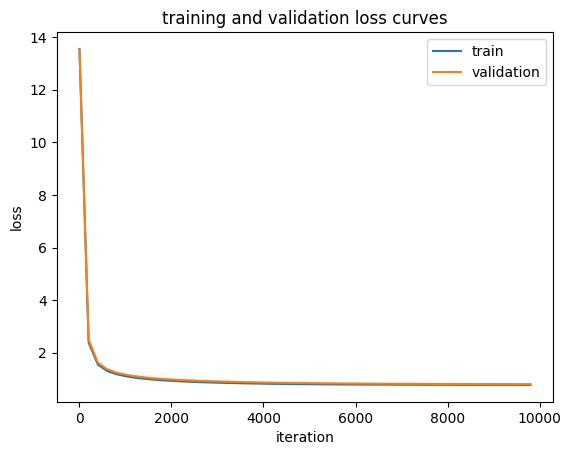

In [25]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

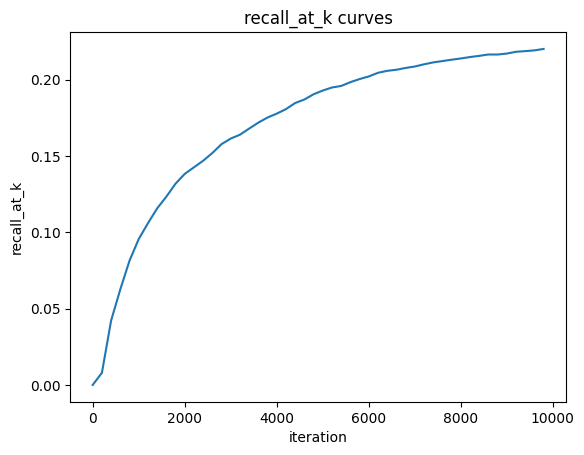

In [26]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

# Evaluation (RMSE)

In [27]:
model.eval()
with torch.no_grad():
    pred_ratings = model.forward(test_edge_index)
    recall_at_k, precision_at_k = get_recall_at_k(test_edge_index, test_edge_values, pred_ratings)
    print(f"recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")


recall_at_k 0.20615, precision_at_k 0.29663


_--------------------- Manual Explore code above 👆🏼 START --------------------------------_

In [ ]:
users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

In [ ]:
print(f"users_emb_final.size() {users_emb_final.size()}")

print(f"items_emb_final.size(): {items_emb_final.size()}")

In [ ]:
# 这里是要 concat 还是要 stack, 我觉得要 concat..。 但是怎么得到的 dimension 不太对? <<==== Here
users_items_emb_final = torch.cat([users_emb_final, items_emb_final], dim=0)

In [64]:
# 这下对了
print(f"users_items_emb_final.size(): {users_items_emb_final.size()}")

users_items_emb_final.size(): torch.Size([10334, 64])


In [43]:
user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
print(f"user_indices {user_indices}, pos_item_indices {pos_item_indices}, neg_item_indices {neg_item_indices}")
    

user_indices tensor([2254]), pos_item_indices tensor([606]), neg_item_indices tensor([6704])


In [49]:
# 全部转成 to(device) 的格式
user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
print(f"user_indices {user_indices}, pos_item_indices {pos_item_indices}, neg_item_indices {neg_item_indices}")


user_indices tensor([2254]), pos_item_indices tensor([606]), neg_item_indices tensor([6704])


In [ ]:

# 拿到第一层，和最后一层的 user embedding?
# 诶，还真是出界了... 
# 因为我 sample mini batch 的时候，在新的 bipartite 格式，是没有考虑 user 还是 item 的
# 这里其实 >610 就是 item 的 index 了，所以这里要处理一下的
# 或者我直接用一个 embedding 不用分成两个..？
# 不过这样 positive_item, negative_item 就会出问题... hmm...
# 这个得想一想怎么弄... 这个是我因为弄 bidirectional 的缘故..
# .. 或者先不弄 birectional?? 不然咋sample 呀??
# 或者这样，我 传给 model 的是 birectional
# 但是给 sampling 用的不是 birectional， 这样就能抱着 positive 和 negative_item sampling 可以用了

users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]

_--------------------- Manual Explore DONE --------------------------------_

In [ ]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [ ]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [ ]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

# bidirectional_test_edge_index = to_bidirectional(test_edge_index)
# bidirectional_test_sparse_edge_index = SparseTensor(
#                                row=bidirectional_test_edge_index[0], 
#                                col=bidirectional_test_edge_index[1], 
#                                sparse_sizes=((num_users + num_movies), num_users + num_movies))



test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                               test_edge_index, 
                                                               test_sparse_edge_index, 
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

发现上面跑出来 效果也一般般
我把原始代码的output 记录一下
- [test_loss: -51.5177, test_recall@10: 0.08269, test_precision@10: 0.05815, test_ndcg@10: 0.09033

卧槽，改了半天 bipartite，改了个寂寞？ (不过我的 iter 用的 500 而不是 10000 好吧，再试一下)
（好像还是不太行，不然我把 bidirectional 拿掉？没有差，好像还是挺差.. 这个真多要歇会儿了... ）

[test_loss: -29.82772, test_recall@10: 0.00317, test_precision@10: 0.00163, test_ndcg@10: 0.00212


TRY: 我试一下只用一层？？(也不想

TRY: 我试一下 threshold 用 >=1
- 不行: [test_loss: -51.26439, test_recall@10: 0.00361, test_precision@10: 0.00127, test_ndcg@10: 0.00182
- 不过我好像有个地方漏改了，所以其实还是 >=4 。。。难怪跟之前一样
- TODO need redo:


Thoughts: 我怀疑我还是 sparse tensor 没有理解对

TRY: 实在不行，把 Bipartate 的处理拿掉？然后用 label encoded 的再跑一下看一下? 然后threshold 用 >=4, 然后 recall@k 的 k 用 20 (然后看一下 perf 会不会至少跟之前例子是持平的，然后再来试一下 bipartite 我把 threshold 该清楚
- [test_loss: -44.70277, test_recall@20: 0.08734, test_precision@20: 0.03558, test_ndcg@20: 0.06751
- 那就跟原始结果差不多
- 发现 threshold at 4 的时候, training density 好低: 
            SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609]),
             col=tensor([   0,    5,   43,  ..., 9443, 9444, 9445]),
             size=(10334, 10334), nnz=79572, density=0.07%)
             
            - 不对，我这已经是用 >=1 和 k = 20 来算的了


_TOTRY_: 用 Bipartite， 而且 threahold 用 >=1
    - 不行， 在前 1500 iter 左右还很低级别就没戏
    
    
_TOTRY_: 改成用原始的 mapping，但是感觉大概率还是不行... 太失望了... 


还发现一个问题，他这每次 train 都是全部一起弄一个 epoch？但是 loss 用的是 batch 的 err? 不太对呀，不是应该

_TOTRY_: 我直接试一下每次 loss 都用整个 batch 的 loss? 而不是 sample batch 的 loss?

_TOTRY_" 我如果不用 sparse matrix?

_Update_: 卧槽，改了 formula 6 的正确写法之后，重要弄出来了 :  ✅

    - [test_loss: -934.20184, test_recall@20: 0.18721, test_precision@20: 0.0367, test_ndcg@20: 0.10241
    - 比原来还是高了不少的 但是真的跑的好久，1h11m... 明天整理一下，然后用 RMSE 试一下
    
_TOTRY_: 发现我应该先 split train/val/test 再转 adj mat 不然有可能 data leak 因为是 symmetric 的


# Make New Recommendatios for a Given User

In [ ]:
# model.eval()
# df = pd.read_csv(movie_path)
# movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
# movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

# user_pos_items = get_user_positive_items(edge_index)

In [ ]:
# def make_predictions(user_id, num_recs):
#     user = user_mapping[user_id]
#     e_u = model.users_emb.weight[user]
    
#     # 这里 @ 是 dot product
#     scores = model.items_emb.weight @ e_u

#     values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

#     movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
#     movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
#     titles = [movieid_title[id] for id in movie_ids]
#     genres = [movieid_genres[id] for id in movie_ids]

#     print(f"Here are some movies that user {user_id} rated highly")
#     for i in range(num_recs):
#         print(f"title: {titles[i]}, genres: {genres[i]} ")

#     print()

#     movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
#     movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
#     titles = [movieid_title[id] for id in movie_ids]
#     genres = [movieid_genres[id] for id in movie_ids]

#     print(f"Here are some suggested movies for user {user_id}")
#     for i in range(num_recs):
#         print(f"title: {titles[i]}, genres: {genres[i]} ")

In [ ]:
# USER_ID = 1
# NUM_RECS = 10

# make_predictions(USER_ID, NUM_RECS)

# Running Log

- 好累呀
- 好像直接卡住了
- 按照 NCF 的写法，改了一下，可以了